In [1]:
# All Includes

import random
import numpy as np
import tensorflow as tf
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf 
from sklearn import metrics
import os
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder



In [2]:
INPUT_SIGNAL_TYPES = [
    "x",
    "y",
    "z",
]


In [3]:
def load_data(window_size):
    path="C:/Users/wangg/PycharmProjects/DEM0089/data_for_dl_test.xlsx_" + str(window_size) + ".csv"
    data=pd.read_csv(path,header=0,index_col=None)
    data.head(10)
    return data

选择对象

In [4]:
def dataset_generate(window_size,data):
    window=int(window_size*50)
    data_subject=np.array(data[data["Label"].isin([1,2,3,4,5,6,7,8])])
    print(data_subject.shape)
    data_subject=np.reshape(data_subject,(-1,window,5))
    print(data_subject.shape)
    X=data_subject[:,:,2:]
    X=X.astype("float64")
    Y=data_subject[:,0,1]
    Y=Y.astype("int")
    print(X.shape)
    print(Y.shape)
    return X,Y

查看数据类别分布

In [5]:
from collections import Counter
def distribution_check(Y):
    Y_count=np.array(Y[:])
    print(Y.shape)
    print(Counter(Y_count))
#     print(Counter(Group))

整数编码

In [6]:
from sklearn.preprocessing import LabelEncoder
def int_encoder(Y):
    label_encoder = LabelEncoder()
    Y = label_encoder.fit_transform(Y)
    print(Counter(Y))
    return Y

In [7]:
#1D卷积
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM,AveragePooling1D
def construct_model(kernel_size,filters_num,pool,window_size_for_model,LSTM_num,class_num,conv_layer_num):
    inputs=tf.keras.Input(shape=(window_size_for_model,3),name='img')
    
    h1=Conv1D(filters=filters_num, kernel_size=kernel_size, strides=1,padding = 'same')(inputs)
    h1=BatchNormalization()(h1)
    h1=tf.keras.layers.Activation("relu")(h1)
    h1=Conv1D(filters=filters_num, kernel_size=kernel_size, strides=1,padding = 'same')(h1)
    h1=BatchNormalization()(h1)
    
#     h1=chan_attnlayer2(64)(h1)
    h2=tf.keras.layers.Activation("relu")(h1)
    h2 = Conv1D(filters=filters_num, kernel_size=kernel_size, strides=1,padding = 'same')(h2)
    h2=BatchNormalization()(h2)
    h2=tf.keras.layers.Activation("relu")(h2)
    h2 = Conv1D(filters=filters_num, kernel_size=kernel_size, strides=1,padding = 'same')(h2)
    h2=BatchNormalization()(h2)
    
    
    h3=tf.keras.layers.Activation("relu")(h2)
        
    h5=LSTM(LSTM_num,input_shape=(window_size_for_model,filters_num),return_sequences = True, name = 'lstm_1')(h3)
    h5=tf.keras.layers.Dropout(0.5, name = 'Dropout_1')(h5)
    
    h6=LSTM(LSTM_num,input_shape=(window_size_for_model,filters_num),return_sequences = False, name = 'lstm_2')(h5)
    h6=tf.keras.layers.Dropout(0.5, name = 'Dropout_2')(h6)

    
    outputs=tf.keras.layers.Dense(class_num, activation = 'softmax', name = 'output')(h6)
    
    model=tf.keras.Model(inputs,outputs,name="CLN")

    opt = tf.keras.optimizers.Adam(learning_rate=0.00005)

    model.compile(optimizer=opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    model.summary() #display model architecture
    return model

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from timeit import default_timer as timer
def model_fit(model,X_train, y_train,X_validation,y_validation,batch_size):
    earlystop_callback=EarlyStopping(monitor="val_loss",patience=5)
    modelcheckpoint=ModelCheckpoint(filepath="best_model.h5",monitor="val_accuracy",save_best_only=True)
    start = timer()
#     class_weight = {0 : 1., 1: 10., 2: 10., 3: 5., 4: 3.}

    history = model.fit( X_train, y_train, epochs = 300,validation_data = (X_validation,y_validation), batch_size=batch_size ,callbacks=[earlystop_callback,modelcheckpoint], verbose=1)
#     validation_data = (X_validation,y_validation)

    end = timer()
    print("\n")
    print("Time: ",(end - start),"secs = ",(end - start)/3600,"hours")


    # ## EVALUATION AND THE PERFORMANCE METRICS

    # In[62]:


    # Plotting loss and accuracy graph
    plt.figure(figsize=(12, 8))

    plt.plot(np.array(history.history['loss']), "r--", label="Train loss")
    plt.plot(np.array(history.history['accuracy']), "g--", label="Train accuracy")

    plt.plot(np.array(history.history['val_loss']), "r-", label="validation loss")
    plt.plot(np.array(history.history['val_accuracy']), "g-", label="validation accuracy")

    plt.title("Training session's progress over iterations(imbalanced data)")
    plt.legend(loc='upper right', shadow=True)
    plt.ylabel('Training Progress (Loss or Accuracy values)')
    plt.xlabel('Training Epoch')
    plt.ylim(0)

    plt.show()

In [9]:
import itertools
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["font.family"] = 'DejaVu Sans'
def plot_confusion_matrix(cm, classes,class_num,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=15)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)
    ax = plt.gca()
    ax.set_ylim(-.5, class_num-0.5)
    ax.set_xlim(-.5, class_num-0.5)
        
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",fontsize=15,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

In [10]:
def model_test(model,X_test,y_test,class_num,LABELS):
#     results = dict()
    test_pred = np.argmax(model.predict(X_test), axis=1)
#     print(test_pred)
    #输出分类结果
#     print(y_test)
#     print(test_pred)
    classfication_report=metrics.classification_report(y_test,test_pred)
    results=float(100*metrics.f1_score(y_test, test_pred, average="macro"))
#     results['classification_report'] = classification_report
    print(classfication_report)
    #输出混淆矩阵
    cm = metrics.confusion_matrix(y_test, test_pred)
    print("Confusion Matrix:")
    print(cm)
    #绘制归一化混淆矩阵
    plt.figure(figsize=(class_num,class_num))
    plt.grid(b=False)
    plot_confusion_matrix(cm, LABELS,class_num, normalize=True, title='Normalized confusion matrix',cmap=plt.cm.Reds)
    ax = plt.gca()
    plt.show()
    #绘制非归一化混淆矩阵
    plt.figure(figsize=(class_num,class_num))
    plot_confusion_matrix(cm, LABELS,class_num, normalize=False, title='confusion matrix',cmap=plt.cm.Reds)
    ax = plt.gca()
    plt.show()
    return results,cm

(543650, 5)
(21746, 25, 5)
(21746, 25, 3)
(21746,)
(21746,)
Counter({8: 3003, 2: 2940, 1: 2900, 4: 2837, 3: 2659, 7: 2655, 6: 2561, 5: 2191})
Counter({7: 3003, 1: 2940, 0: 2900, 3: 2837, 2: 2659, 6: 2655, 5: 2561, 4: 2191})
Counter({7: 2402, 1: 2352, 0: 2320, 3: 2269, 2: 2127, 6: 2124, 5: 2049, 4: 1753})
[0 0 0 ... 7 7 7]
(17396,)
(4350,)
Counter({7: 601, 1: 588, 0: 580, 3: 568, 2: 532, 6: 531, 5: 512, 4: 438})
Counter({7: 1921, 1: 1881, 0: 1856, 3: 1815, 2: 1702, 6: 1699, 5: 1640, 4: 1402})
Counter({7: 481, 1: 471, 0: 464, 3: 454, 2: 425, 6: 425, 5: 409, 4: 351})
Model: "CLN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 25, 3)]           0         
                                                                 
 conv1d (Conv1D)             (None, 25, 256)           2560      
                                                                 
 batch_normalization

Epoch 33/300
55/55 [==============================] - 2s 29ms/step - loss: 0.1060 - accuracy: 0.9755 - val_loss: 0.1820 - val_accuracy: 0.9543
Epoch 34/300
55/55 [==============================] - 2s 29ms/step - loss: 0.1025 - accuracy: 0.9762 - val_loss: 0.1729 - val_accuracy: 0.9560
Epoch 35/300
55/55 [==============================] - 2s 29ms/step - loss: 0.1026 - accuracy: 0.9753 - val_loss: 0.1682 - val_accuracy: 0.9557
Epoch 36/300
55/55 [==============================] - 2s 30ms/step - loss: 0.0928 - accuracy: 0.9797 - val_loss: 0.1701 - val_accuracy: 0.9569


Time:  65.3817822 secs =  0.018161606166666667 hours


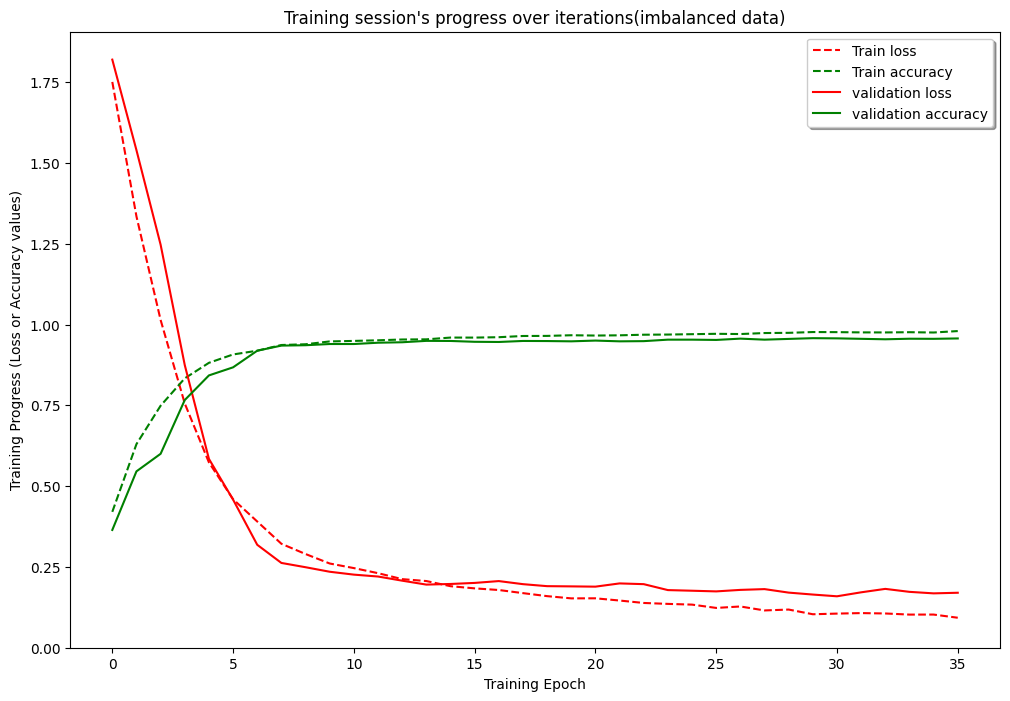

136/136 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       580
           1       0.96      0.97      0.96       588
           2       0.93      0.95      0.94       532
           3       0.99      0.96      0.98       568
           4       0.97      0.97      0.97       438
           5       0.97      0.95      0.96       512
           6       0.96      0.98      0.97       531
           7       0.96      0.96      0.96       601

    accuracy                           0.96      4350
   macro avg       0.96      0.96      0.96      4350
weighted avg       0.96      0.96      0.96      4350

Confusion Matrix:
[[556   5   7   1   0   5   1   5]
 [  8 571   6   0   0   0   0   3]
 [  4   8 507   1   2   3   1   6]
 [  0   0   2 546   5   1  13   1]
 [  0   6   2   0 426   1   1   2]
 [  3   3   8   1   6 487   2   2]
 [  0   0   6   1   1   2 519   2]
 [  2   4   7   2   0   3   5 5

C:\Users\wangg\AppData\Local\Temp\ipykernel_16964\2134637361.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


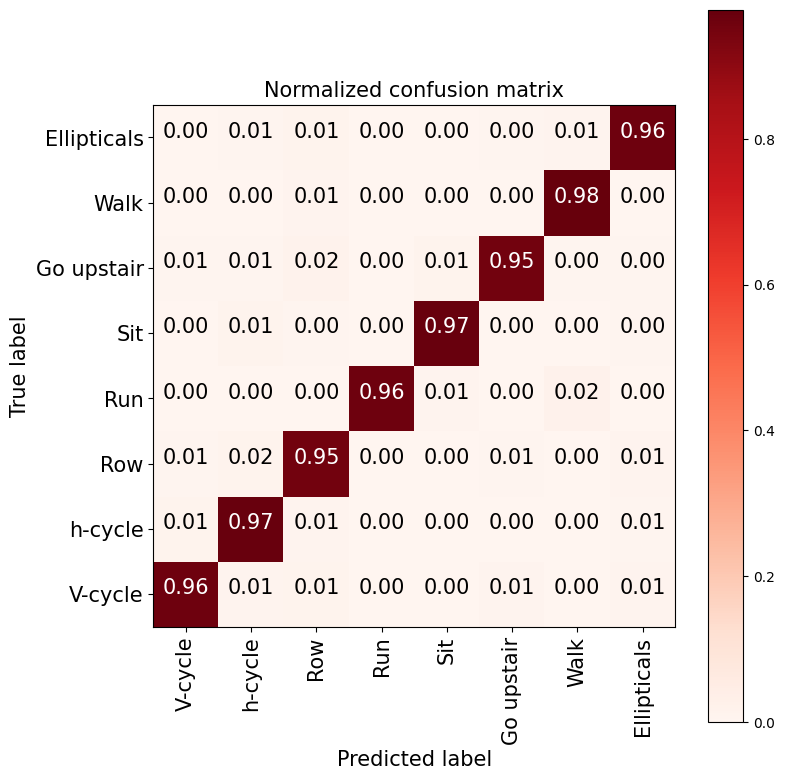

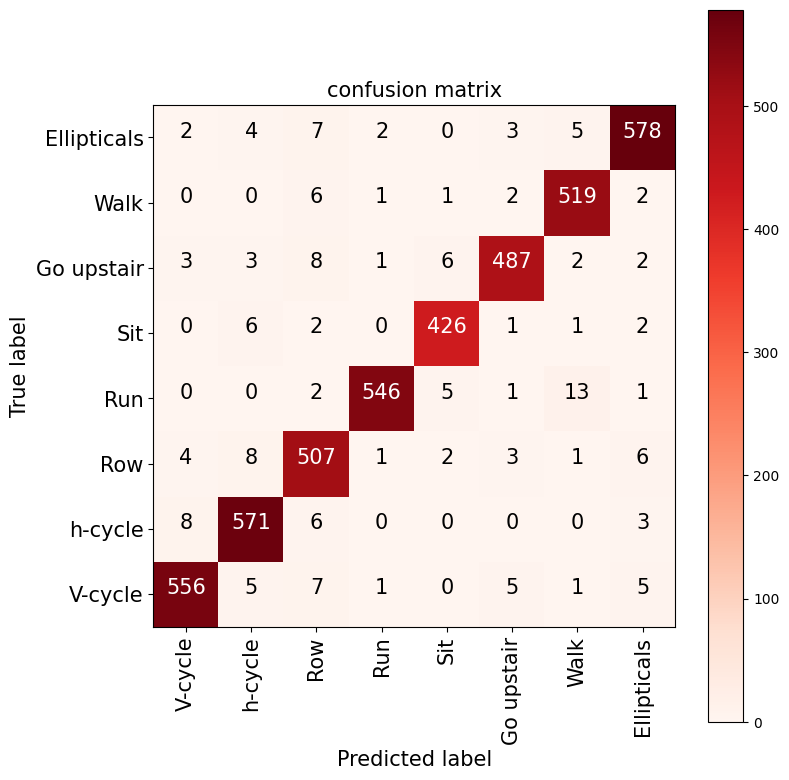

[[556.   5.   7.   1.   0.   5.   1.   5.]
 [  8. 571.   6.   0.   0.   0.   0.   3.]
 [  4.   8. 507.   1.   2.   3.   1.   6.]
 [  0.   0.   2. 546.   5.   1.  13.   1.]
 [  0.   6.   2.   0. 426.   1.   1.   2.]
 [  3.   3.   8.   1.   6. 487.   2.   2.]
 [  0.   0.   6.   1.   1.   2. 519.   2.]
 [  2.   4.   7.   2.   0.   3.   5. 578.]]
0.5的average-macro-f1-score:96.3288983474873%
(521650, 5)
(10433, 50, 5)
(10433, 50, 3)
(10433,)
(10433,)
Counter({8: 1441, 2: 1411, 1: 1391, 4: 1361, 3: 1276, 7: 1273, 6: 1229, 5: 1051})
Counter({7: 1441, 1: 1411, 0: 1391, 3: 1361, 2: 1276, 6: 1273, 5: 1229, 4: 1051})
Counter({7: 1153, 1: 1129, 0: 1112, 3: 1089, 2: 1021, 6: 1018, 5: 983, 4: 841})
[0 0 0 ... 7 7 7]
(8346,)
(2087,)
Counter({7: 288, 1: 282, 0: 279, 3: 272, 2: 255, 6: 255, 5: 246, 4: 210})
Counter({7: 922, 1: 903, 0: 889, 3: 871, 2: 817, 6: 814, 5: 787, 4: 673})
Counter({7: 231, 1: 226, 0: 223, 3: 218, 2: 204, 6: 204, 5: 196, 4: 168})
Model: "CLN"
_____________________________________

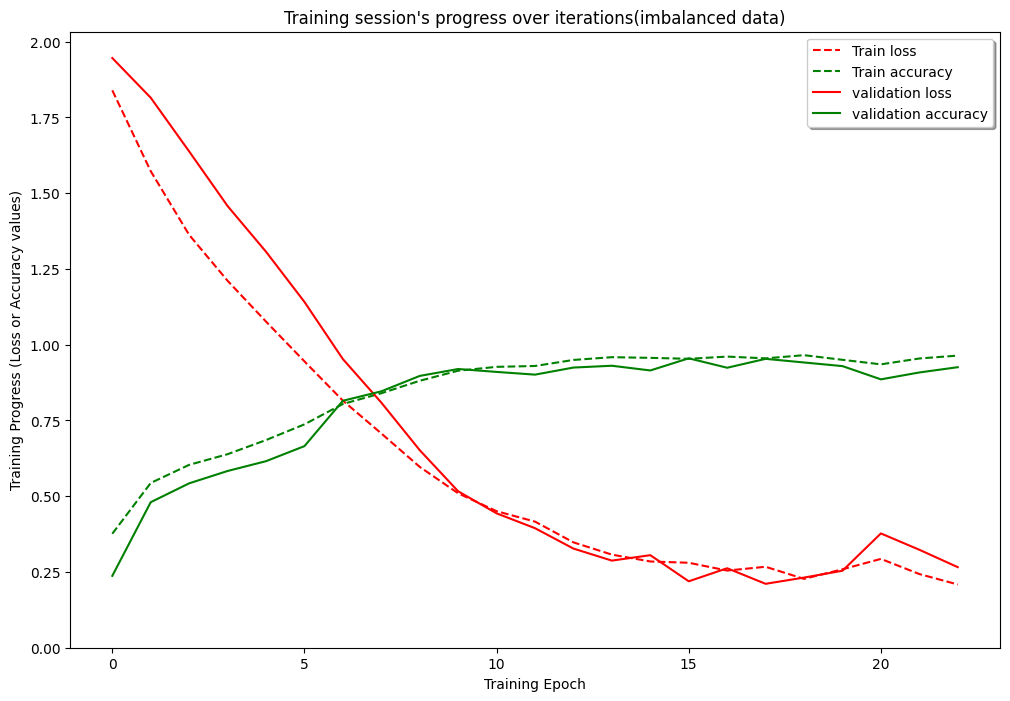

66/66 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       1.00      0.72      0.84       279
           1       0.92      0.96      0.94       282
           2       0.78      0.95      0.85       255
           3       0.99      0.96      0.97       272
           4       0.91      0.97      0.94       210
           5       0.94      0.97      0.95       246
           6       0.97      0.94      0.95       255
           7       0.96      0.96      0.96       288

    accuracy                           0.93      2087
   macro avg       0.93      0.93      0.93      2087
weighted avg       0.93      0.93      0.93      2087

Confusion Matrix:
[[202  14  57   0   1   4   1   0]
 [  0 270   8   0   2   2   0   0]
 [  0   6 242   1   1   3   1   1]
 [  0   0   2 261   3   2   4   0]
 [  0   4   0   0 203   1   0   2]
 [  0   0   1   1   5 239   0   0]
 [  0   0   1   1   1   3 239  10]
 [  0   1   1   0   7   1   1 277

C:\Users\wangg\AppData\Local\Temp\ipykernel_16964\2134637361.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


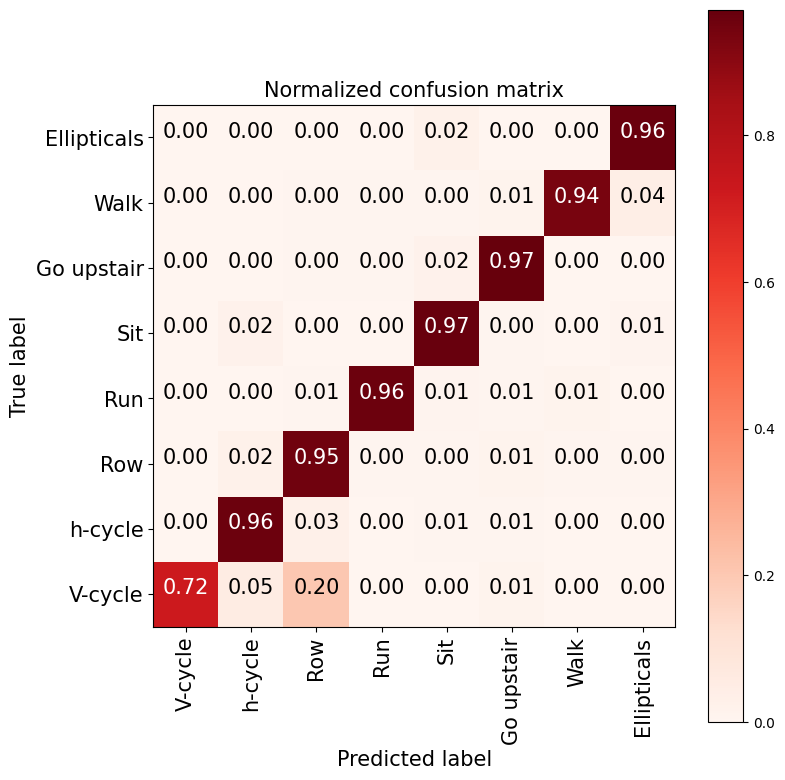

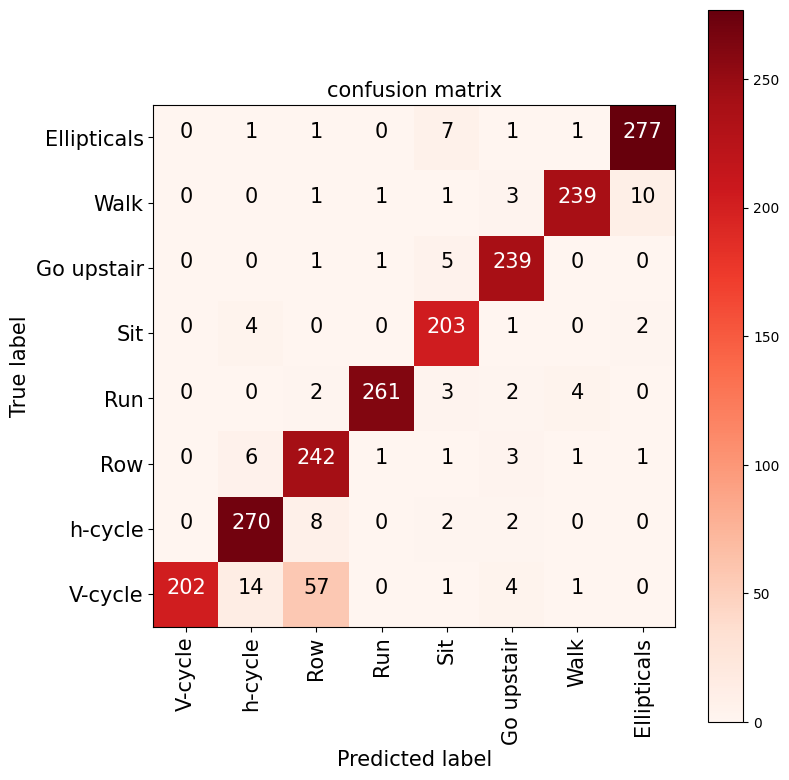

[[202.  14.  57.   0.   1.   4.   1.   0.]
 [  0. 270.   8.   0.   2.   2.   0.   0.]
 [  0.   6. 242.   1.   1.   3.   1.   1.]
 [  0.   0.   2. 261.   3.   2.   4.   0.]
 [  0.   4.   0.   0. 203.   1.   0.   2.]
 [  0.   0.   1.   1.   5. 239.   0.   0.]
 [  0.   0.   1.   1.   1.   3. 239.  10.]
 [  0.   1.   1.   0.   7.   1.   1. 277.]]
1的average-macro-f1-score:92.59492071297713%
(528450, 5)
(7046, 75, 5)
(7046, 75, 3)
(7046,)
(7046,)
Counter({8: 973, 2: 953, 1: 940, 4: 919, 3: 861, 7: 860, 6: 830, 5: 710})
Counter({7: 973, 1: 953, 0: 940, 3: 919, 2: 861, 6: 860, 5: 830, 4: 710})
Counter({7: 778, 1: 762, 0: 752, 3: 735, 2: 689, 6: 688, 5: 664, 4: 568})
[0 0 0 ... 7 7 7]
(5636,)
(1410,)
Counter({7: 195, 1: 191, 0: 188, 3: 184, 2: 172, 6: 172, 5: 166, 4: 142})
Counter({7: 622, 1: 610, 0: 601, 3: 588, 2: 551, 6: 550, 5: 532, 4: 454})
Counter({7: 156, 1: 152, 0: 151, 3: 147, 2: 138, 6: 138, 5: 132, 4: 114})
Model: "CLN"
________________________________________________________________

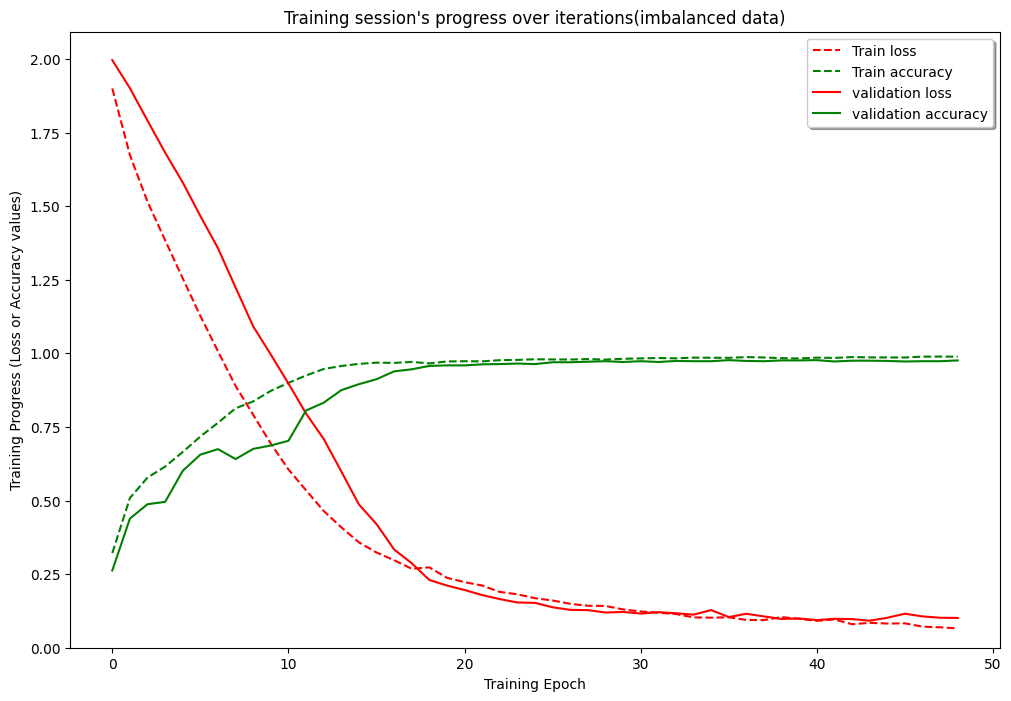

45/45 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       188
           1       0.97      0.99      0.98       191
           2       0.96      0.99      0.97       172
           3       0.99      0.98      0.99       184
           4       0.98      0.98      0.98       142
           5       0.98      0.97      0.98       166
           6       0.97      0.98      0.97       172
           7       0.99      0.95      0.97       195

    accuracy                           0.98      1410
   macro avg       0.98      0.98      0.98      1410
weighted avg       0.98      0.98      0.98      1410

Confusion Matrix:
[[186   0   0   0   0   0   1   1]
 [  0 190   1   0   0   0   0   0]
 [  0   1 170   0   0   1   0   0]
 [  0   0   0 180   2   0   2   0]
 [  0   1   1   0 139   1   0   0]
 [  1   0   2   1   1 161   0   0]
 [  1   1   2   0   0   0 168   0]
 [  1   3   2   0   0   1   3 18

C:\Users\wangg\AppData\Local\Temp\ipykernel_16964\2134637361.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


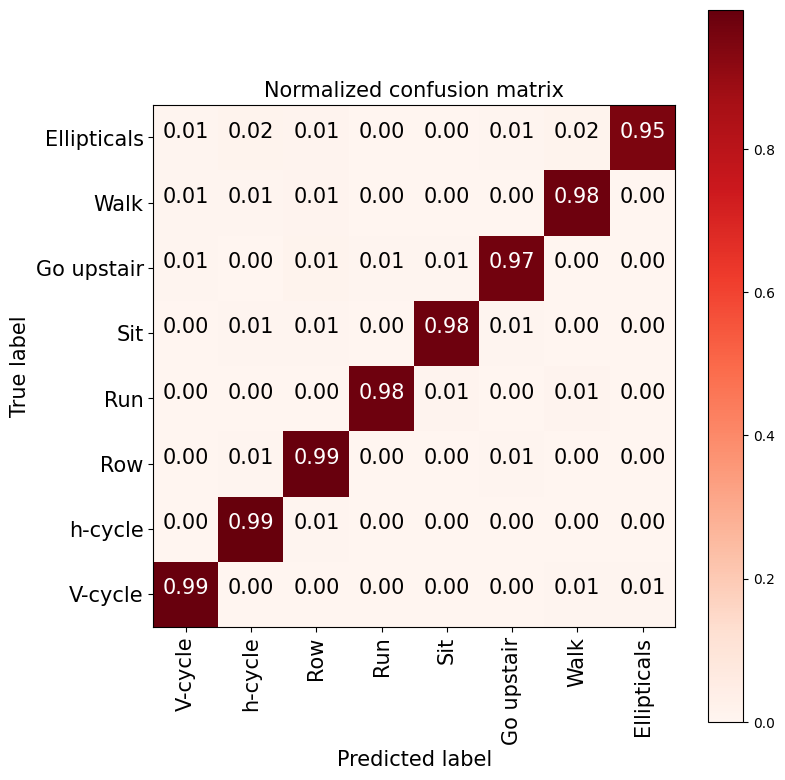

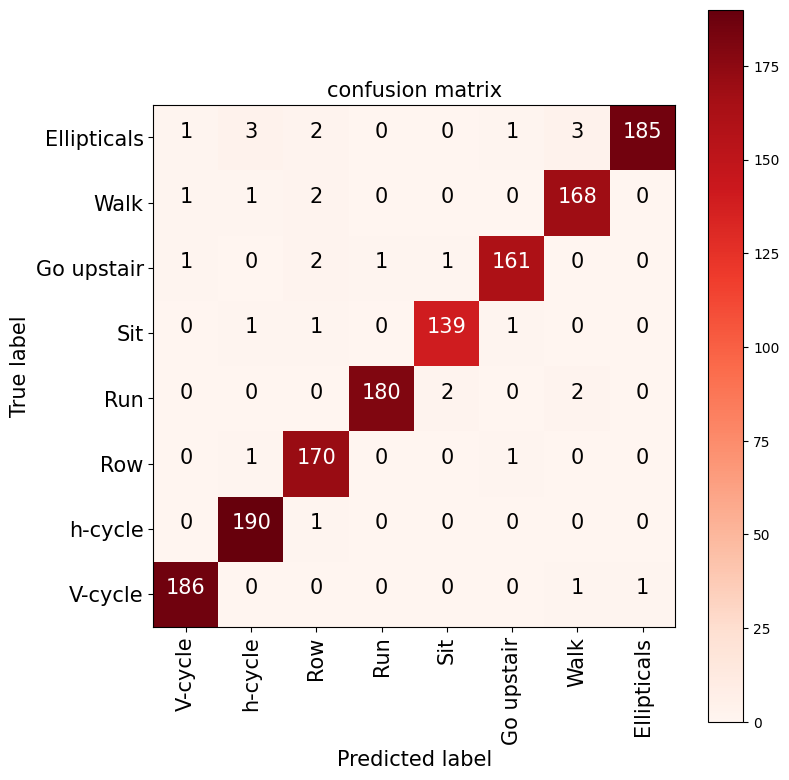

[[186.   0.   0.   0.   0.   0.   1.   1.]
 [  0. 190.   1.   0.   0.   0.   0.   0.]
 [  0.   1. 170.   0.   0.   1.   0.   0.]
 [  0.   0.   0. 180.   2.   0.   2.   0.]
 [  0.   1.   1.   0. 139.   1.   0.   0.]
 [  1.   0.   2.   1.   1. 161.   0.   0.]
 [  1.   1.   2.   0.   0.   0. 168.   0.]
 [  1.   3.   2.   0.   0.   1.   3. 185.]]
1.5的average-macro-f1-score:97.79046470673707%
(521200, 5)
(5212, 100, 5)
(5212, 100, 3)
(5212,)
(5212,)
Counter({8: 720, 2: 705, 1: 695, 4: 680, 3: 637, 7: 636, 6: 614, 5: 525})
Counter({7: 720, 1: 705, 0: 695, 3: 680, 2: 637, 6: 636, 5: 614, 4: 525})
Counter({7: 576, 1: 564, 0: 556, 3: 544, 2: 509, 6: 509, 5: 491, 4: 420})
[0 0 0 ... 7 7 7]
(4169,)
(1043,)
Counter({7: 144, 1: 141, 0: 139, 3: 136, 2: 128, 6: 127, 5: 123, 4: 105})
Counter({7: 461, 1: 452, 0: 444, 3: 435, 2: 407, 6: 407, 5: 393, 4: 336})
Counter({7: 115, 0: 112, 1: 112, 3: 109, 2: 102, 6: 102, 5: 98, 4: 84})
Model: "CLN"
______________________________________________________________

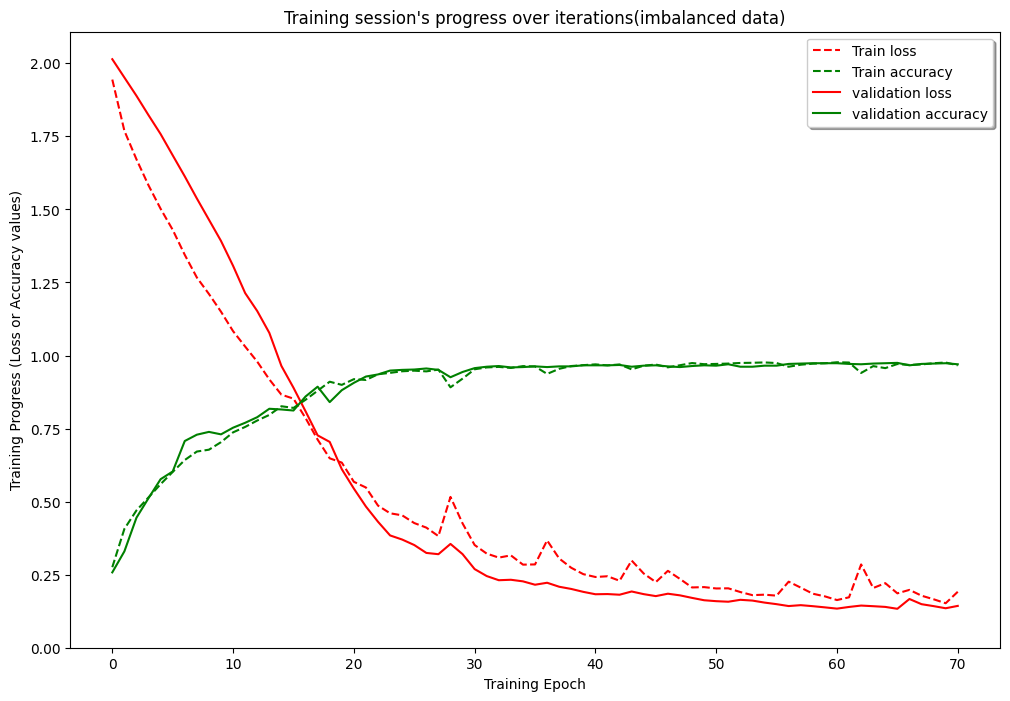

33/33 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       139
           1       0.93      1.00      0.97       141
           2       0.96      0.95      0.96       128
           3       0.99      0.96      0.98       136
           4       0.90      0.98      0.94       105
           5       0.94      0.97      0.96       123
           6       0.97      0.96      0.96       127
           7       1.00      0.94      0.97       144

    accuracy                           0.96      1043
   macro avg       0.96      0.96      0.96      1043
weighted avg       0.96      0.96      0.96      1043

Confusion Matrix:
[[130   3   3   0   2   1   0   0]
 [  0 141   0   0   0   0   0   0]
 [  0   5 122   0   0   0   1   0]
 [  0   0   0 131   1   2   2   0]
 [  1   1   0   0 103   0   0   0]
 [  1   0   0   1   2 119   0   0]
 [  0   0   0   0   2   3 122   0]
 [  0   1   2   0   4   1   1 13

C:\Users\wangg\AppData\Local\Temp\ipykernel_16964\2134637361.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


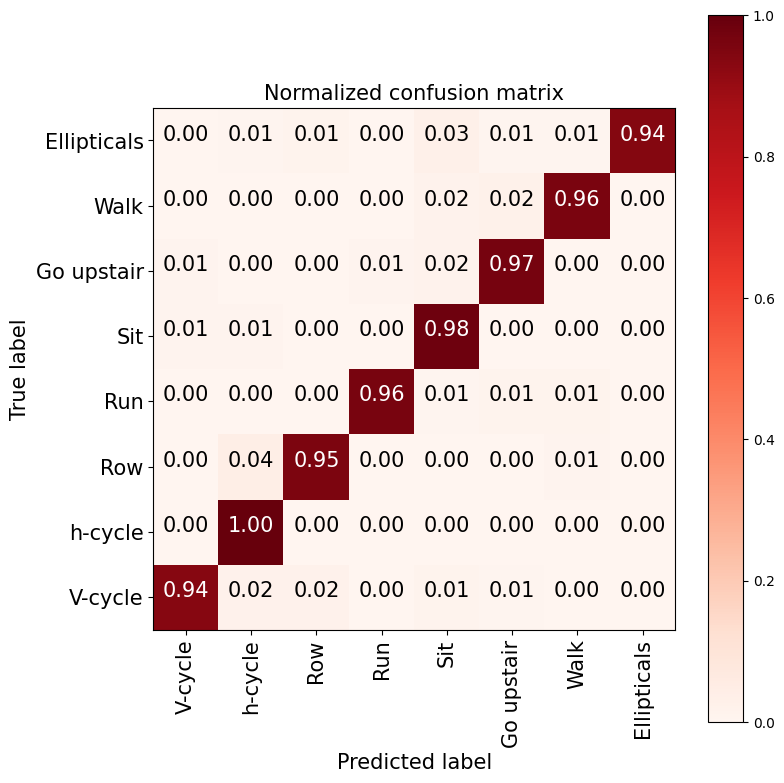

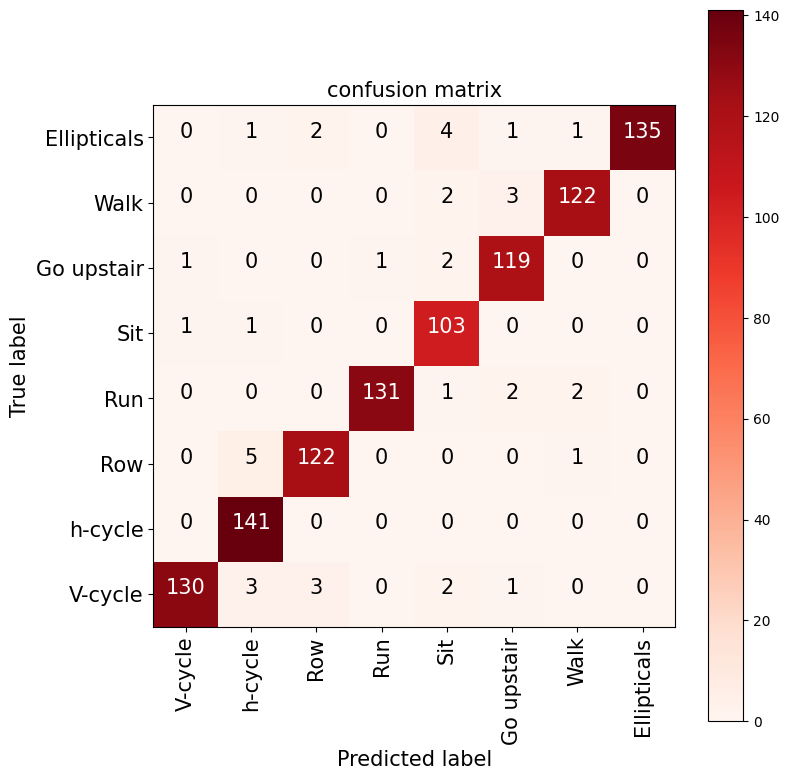

[[130.   3.   3.   0.   2.   1.   0.   0.]
 [  0. 141.   0.   0.   0.   0.   0.   0.]
 [  0.   5. 122.   0.   0.   0.   1.   0.]
 [  0.   0.   0. 131.   1.   2.   2.   0.]
 [  1.   1.   0.   0. 103.   0.   0.   0.]
 [  1.   0.   0.   1.   2. 119.   0.   0.]
 [  0.   0.   0.   0.   2.   3. 122.   0.]
 [  0.   1.   2.   0.   4.   1.   1. 135.]]
2的average-macro-f1-score:96.10336349604165%


In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

skf1 = StratifiedKFold(n_splits=5,shuffle=True)
skf2 = StratifiedKFold(n_splits=5,shuffle=True)

window_sizes=[0.5,1,1.5,2]

for window_size in window_sizes:

    data=load_data(window_size)
    class_num=8

    LABELS = [ "V-cycle","h-cycle","Row","Run","Sit","Go upstair","Walk","Ellipticals"]


    
    X,Y=dataset_generate(window_size,data)
    distribution_check(Y)
    Y=int_encoder(Y)


    average_macrof1_score=0.0
    num=1
    confusion_matrix=np.zeros((class_num,class_num))
    for train_total_index, test_index in skf1.split(X, Y):

        X_test, y_test = X[test_index],Y[test_index]
        X_train_total,y_train_total=X[train_total_index],Y[train_total_index]
#                             X_train_total,y_train_total=smote(X_train_total,y_train_total)
        print(Counter(y_train_total))
        X_train, y_train = [],[]
        X_validation,y_validation=[],[]
        print(y_train_total)
        number=1
        for train_index, validation_index in skf1.split(X_train_total, y_train_total):
            if number==1:
                X_train, y_train = X_train_total[train_index],y_train_total[train_index]
                X_validation,y_validation=X_train_total[validation_index],y_train_total[validation_index]
                number=number+1
            else:
                break
    #     Group_train_total=Group[train_total_index]
        print(train_total_index.shape)
        print(test_index.shape)
        print(Counter(y_test))
        print(Counter(y_train))
        print(Counter(y_validation))

        model=construct_model(conv_layer_num=2 ,kernel_size=3,filters_num=256,pool=3,window_size_for_model=int(window_size*50),LSTM_num=64,class_num=class_num)
        model_fit(model,X_train=X_train,y_train=y_train,X_validation=X_validation,y_validation=y_validation,batch_size=256)
        results,confusion_matrix_temp=model_test(model,X_test=X_test,y_test=y_test,class_num=class_num,LABELS=LABELS)
    #     print(results['f1-score'])
        average_macrof1_score=average_macrof1_score + results
        confusion_matrix=confusion_matrix+confusion_matrix_temp
        del model
    #         break
        num=num+1
        break

    print(confusion_matrix)
    print(str(window_size)+"的average-macro-f1-score:"+str(average_macrof1_score/(num-1))+"%")



